In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor
import cv2
import shutil
import PIL

from fastai import *
from fastai.vision import *

The drawings for this competition are described in csv files. We will go from the description to actual images on our hard drives - this will allow us to train using the familiar ImageDataBunch.from_name_re

If you are interested to learn more about the data format, you can find more information [here](https://www.kaggle.com/inversion/getting-started-viewing-quick-draw-doodles-etc).

In [5]:
ls data/train | head

airplane.csv*
alarm clock.csv*
ambulance.csv*
angel.csv*
animal migration.csv*
ant.csv*
anvil.csv*
apple.csv*
arm.csv*
asparagus.csv*


Let's see how many images per class do we have. It takes a while to parse 7GB+ of csvs so I am running the code in parallel. If you are not familiar with this part of the Python API, do not worry!. This only speeds the code up a bit and there is rarely a genuine need to go this route.

In [6]:
%%time
def get_counts(path): return (path.stem, pd.read_csv(path).shape[0])
with ThreadPoolExecutor(12) as e: counts = list(e.map(get_counts, Path('data/train').iterdir()))

CPU times: user 5min 8s, sys: 30.9 s, total: 5min 38s
Wall time: 3min 40s


This still took forever! Let's see what we got:

In [10]:
counts

[('pear', 116904),
 ('golf club', 194843),
 ('violin', 217260),
 ('flashlight', 239763),
 ('swing set', 119357),
 ('lighthouse', 160903),
 ('broccoli', 132826),
 ('sandwich', 131732),
 ('purse', 123320),
 ('cookie', 131353),
 ('fan', 136158),
 ('zigzag', 120072),
 ('power outlet', 169462),
 ('feather', 119910),
 ('owl', 169632),
 ('radio', 135728),
 ('tree', 144721),
 ('frog', 159047),
 ('popsicle', 126707),
 ('streetlight', 123280),
 ('peanut', 126626),
 ('ladder', 125389),
 ('snowflake', 116685),
 ('banana', 307936),
 ('train', 127948),
 ('eraser', 118339),
 ('snail', 133757),
 ('moon', 121661),
 ('flip flops', 121518),
 ('barn', 151139),
 ('mosquito', 123029),
 ('axe', 124122),
 ('duck', 135480),
 ('The Mona Lisa', 121383),
 ('bench', 128695),
 ('hockey stick', 130110),
 ('grass', 123071),
 ('camel', 121399),
 ('picture frame', 122371),
 ('dragon', 124362),
 ('pickup truck', 130740),
 ('butterfly', 117999),
 ('elbow', 126253),
 ('helmet', 121899),
 ('shovel', 117194),
 ('ceiling fan

In [7]:
sorted_counts = sorted(counts, key=lambda tup: tup[1])

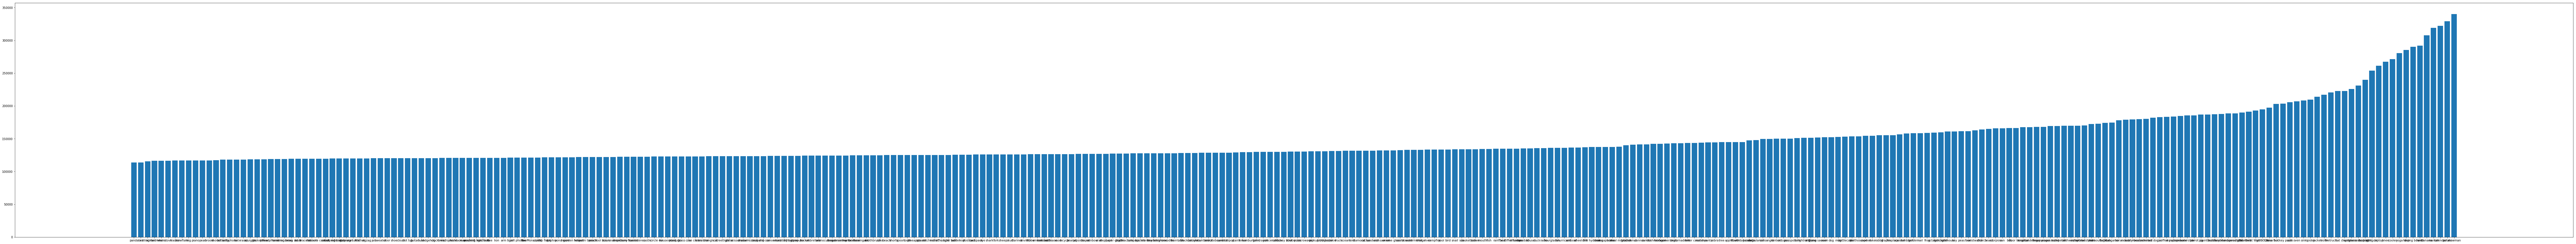

In [12]:
plt.bar([tup[0] for tup in sorted_counts], [tup[1] for tup in sorted_counts])
#plt.xticks(ticks=[], rotation='vertical');
fig = plt.gcf()
fig.set_size_inches(160, 15)

In [13]:
sorted_counts[:10]

[('panda', 113613),
 ('bed', 113862),
 ('ceiling fan', 115413),
 ('screwdriver', 116313),
 ('whale', 116502),
 ('stove', 116535),
 ('tractor', 116677),
 ('snowflake', 116685),
 ('leg', 116804),
 ('piano', 116870)]

In [14]:
sorted_counts[-10:]

[('cooler', 271444),
 ('yoga', 280442),
 ('harp', 285403),
 ('diving board', 290239),
 ('hand', 291773),
 ('banana', 307936),
 ('marker', 319136),
 ('calendar', 321981),
 ('potato', 329204),
 ('snowman', 340029)]

In [15]:
np.sum([tup[1] for tup in counts]), len(counts)

(49707579, 340)

We have 340 classes and a total of ~50 million drawings. The least represented class is a panda at 113 613 samples and the most represented class is a snowman with 340 039 samples. Assuming the quality of drawings does not vary much, this is not a class imbalance at all!

Maybe test images contain a similar class distribution? Having ~500k images seems like a nice place to start. Let's randomly pick 1% of images from each category and save them as jpg files.

But first, lets take a look at the data quickly.

In [16]:
df = pd.read_csv('data/train/snowman.csv')

In [17]:
df.head()

,countrycode,drawing,key_id,recognized,timestamp,word
0,SG,"[[[51, 37, 31, 33, 39, 56, 74, 88, 101, 106, 1...",5040959249186816,True,2017-03-19 13:09:20.410260,snowman
1,GB,"[[[128, 102, 73, 42, 36, 40, 55, 81, 112, 131,...",5057709479034880,True,2017-04-01 00:23:56.920640,snowman
2,US,"[[[95, 74, 56, 40, 36, 40, 53, 75, 89, 119, 13...",4649154502459392,True,2017-01-28 22:52:14.740020,snowman
3,US,"[[[17, 17], [36, 36]], [[14, 14, 26, 51, 58, 8...",5668944822140928,False,2017-03-02 19:02:04.755340,snowman
4,US,"[[[129, 116, 95, 79, 76, 79, 87, 111, 130, 139...",5670608501211136,True,2017-03-21 21:59:23.444070,snowman


In [18]:
# https://www.kaggle.com/gaborfodor/greyscale-mobilenet-lb-0-892
BASE_SIZE = 256
def draw_cv2(raw_strokes, size=256, lw=4, time_color=False):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    img = cv2.copyMakeBorder(img,4,4,4,4,cv2.BORDER_CONSTANT)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size), interpolation=cv2.INTER_LINEAR)
    else:
        return img

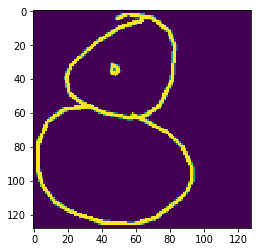

In [24]:
plt.imshow(draw_cv2(eval(df.loc[1, 'drawing']), size=128))

We know how to generate images, we have looked at the data. Time to write images to disk and start training!

In [25]:
sz = 128 # size
r = 0.01 # portion of images to keep, we want only 1% of total train data
shutil.rmtree(f'data/train-{sz}', ignore_errors=True) # deleting whatever we have saved earlier
os.makedirs(f'data/train-{sz}') # best to have where to save the images

In [26]:
def save_ims_from_df(path):
    df = pd.read_csv(path)
    selected = df[df.recognized==True].sample(int(r * df.shape[0]))
    for row in selected.iterrows():
        idx, drawing, label = row[0], eval(row[1].drawing), '_'.join(row[1].word.split())
        ary = draw_cv2(drawing, size=128)
        rgb_ary = np.repeat(ary[:,:,None], 3, -1)
        PIL.Image.fromarray(rgb_ary).save(f'data/train-{sz}/{label}_{idx}.png')

In [27]:
%%time
with ThreadPoolExecutor(12) as e: e.map(save_ims_from_df, Path('data/train').iterdir())

CPU times: user 33min 44s, sys: 13min 44s, total: 47min 28s
Wall time: 19min 43s


A few of sanity checks

In [28]:
ls data/train-{sz} -lhS | head -n 10

total 2.0G
-rw-r--r-- 1 jupyter jupyter 7.5K Nov  2 13:29 blackberry_55892.png
-rw-r--r-- 1 jupyter jupyter 7.5K Nov  2 13:40 squiggle_14399.png
-rw-r--r-- 1 jupyter jupyter 7.2K Nov  2 13:29 blackberry_88948.png
-rw-r--r-- 1 jupyter jupyter 7.2K Nov  2 13:29 blackberry_92100.png
-rw-r--r-- 1 jupyter jupyter 7.1K Nov  2 13:29 blackberry_100117.png
-rw-r--r-- 1 jupyter jupyter 7.1K Nov  2 13:31 hockey_puck_192096.png
-rw-r--r-- 1 jupyter jupyter 7.1K Nov  2 13:31 hockey_puck_18125.png
-rw-r--r-- 1 jupyter jupyter 7.1K Nov  2 13:29 blackberry_62207.png
-rw-r--r-- 1 jupyter jupyter 7.1K Nov  2 13:29 blackberry_49539.png
ls: write error: Broken pipe


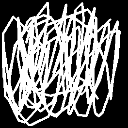

In [31]:
PIL.Image.open(f'data/train-{sz}/squiggle_14399.png')

Seems to have worked. We now need to generating the test set.

In [33]:
df = pd.read_csv('data/test_simplified.csv')

In [35]:
df.head()

,key_id,countrycode,drawing
0,9000003627287624,DE,"[[[17, 18, 20, 25, 137, 174, 242, 249, 251, 25..."
1,9000010688666847,UA,"[[[174, 145, 106, 38, 11, 4, 4, 15, 29, 78, 16..."
2,9000023642890129,BG,"[[[0, 12, 14, 17, 16, 24, 55, 57, 60, 79, 82, ..."
3,9000038588854897,US,"[[[0, 9, 23, 40, 54, 60, 81, 105, 123, 167, 20..."
4,9000052667981386,AR,"[[[87, 82, 71, 63, 66, 92, 96, 95], [220, 218,..."


In [37]:
df.shape

(112199, 3)

In [38]:
shutil.rmtree(f'data/test-{sz}', ignore_errors=True)
os.makedirs(f'data/test-{sz}')

In [39]:
def save_test_ims_from_df(path):
    df = pd.read_csv(path)
    for row in df.iterrows():
        key_id, drawing = row[1].key_id, eval(row[1].drawing)
        ary = draw_cv2(drawing, size=128)
        rgb_ary = np.repeat(ary[:,:,None], 3, -1)
        PIL.Image.fromarray(rgb_ary).save(f'data/test-{sz}/{key_id}.png')

In [40]:
%time save_test_ims_from_df('data/test_simplified.csv')

CPU times: user 3min 29s, sys: 0 ns, total: 3min 29s
Wall time: 3min 30s


In [41]:
ls -lht data/test-128 | head -n 10

total 457M
-rw-r--r-- 1 jupyter jupyter 1.9K Nov  2 13:57 9999996442242305.png
-rw-r--r-- 1 jupyter jupyter 2.4K Nov  2 13:57 9999968529902445.png
-rw-r--r-- 1 jupyter jupyter 2.6K Nov  2 13:57 9999969540362833.png
-rw-r--r-- 1 jupyter jupyter 2.1K Nov  2 13:57 9999946504414373.png
-rw-r--r-- 1 jupyter jupyter 2.6K Nov  2 13:57 9999967586702768.png
-rw-r--r-- 1 jupyter jupyter 2.1K Nov  2 13:57 9999904523466068.png
-rw-r--r-- 1 jupyter jupyter  266 Nov  2 13:57 9999910529948270.png
-rw-r--r-- 1 jupyter jupyter 2.5K Nov  2 13:57 9999938440174842.png
-rw-r--r-- 1 jupyter jupyter 2.5K Nov  2 13:57 9999882665666317.png
ls: write error: Broken pipe


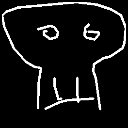

In [46]:
PIL.Image.open('data/test-128/9999967586702768.png')

In [50]:
#Training Data
!ls -lt data/train-128/ | wc -l

496914


In [51]:
#Testing Data
!ls -lt data/test-128/ | wc -l

112200
